## Plots to help with visual analysis of data

### Initial planned contents:
- baseline plot, shows the average tier rates for a prolonged period of time > 1yr
- ?

Import data and set up dataframes, courtesy of Dhruv

In [6]:
import cadspy
import numpy as np 
import pandas as pd
from datetime import datetime as dt
from itertools import combinations
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
icw = cadspy.DatabaseConnection(system='ICW', user='n518899')

In [9]:
# lounge eligibility data
query = """
sel * from LDB_SBOX_OR.HACKATHON_OPS_LOUNGE_ELIGIBILITY
"""
df_lounge_eligibility = icw.queryToDataframe(query)

# flight info data
query = """
select * from LDB_SBOX_OR.HACKATHON_OPS_FLIGHT_INFO
"""
df_flight_info = icw.queryToDataframe(query)

# country decode data
query = """
select * from LDB_SBOX_OR.HACKATHON_OPS_COUNTRY_DECODE
"""
df_country = icw.queryToDataframe(query)

# AC_type
query = """
select * from LDB_SBOX_OR.HACKATHON_OPS_AC_TYPE
"""
df_acft_typ = icw.queryToDataframe(query)

'''
geo_query = """
SELECT 
	* 
FROM 
	REF_RAS_GEOGRAPHY RRG_O
	
WHERE
	RRG_O.STN_CD <> ''
"""

df_geo = icw.queryToDataframe(geo_query)
'''

# capital city data
df_cap_city = pd.read_csv('https://raw.githubusercontent.com/icyrockcom/country-capitals/master/data/country-list.csv')



In [10]:
def headers_and_first_row(df):
    '''
    print headers and first row of a df to deal with data types
    '''
    
    headers = df.columns
    first_row = []

    for col in headers:
        first_row.append(df[col][0])
    
    dictionary = dict( zip( headers, first_row) )

    return dictionary

In [11]:
def dataframe_str_formatter(df):
    '''Strips all whitespace in string columns in DataFrame'''
    for col in df.columns:
        if isinstance(df[col][0],str):
            df[col] = df[col].str.strip()
        else:
            continue
    return df

In [12]:
format_df = headers_and_first_row(df_lounge_eligibility)

In [13]:
df_lounge_eligibility = dataframe_str_formatter(df_lounge_eligibility)

df_lounge_eligibility['GMT_UPLIFT_DT'] = pd.to_datetime(df_lounge_eligibility['GMT_UPLIFT_DT'])

### df_flight_info  preprocessing 

In [14]:
# pre-processing code

df_flight_info = dataframe_str_formatter(df_flight_info)

# Need to convert to same date type for merge
df_flight_info['GMT_PLND_DEP_TS'] = pd.to_datetime(df_flight_info['GMT_PLND_DEP_TS'], format = '%Y-%m-%d')
df_flight_info['GMT_PLND_DEP'] = pd.to_datetime(df_flight_info['GMT_PLND_DEP_TS'].dt.date)

### df_country preprocessing

In [15]:
df_country = dataframe_str_formatter(df_country)

### df_act_type preprocessing

In [16]:
df_acft_type = dataframe_str_formatter(df_acft_typ)

### joining data

In [17]:
df_lounge_elig_flight_info = pd.merge(df_lounge_eligibility,# left table
                                     df_flight_info, # right table
                                     left_on = ['GMT_UPLIFT_DT','OPERATING_FLT_NO','UPLIFT_STN_CD','DISCHARGE_STN_CD'], # left on? e.g. which columns from the left table are you joining on to?
                                     right_on = ['GMT_PLND_DEP','OPG_FLT_NO','ACT_DEP_STN_CD','ACT_ARR_STN_CD'], # right on? # left on? e.g. which columns from the right table are you joining on to?
                                     how = "left" # how? e.g. left, right, inner,etc
                                     )

print('Old Shape: {}'.format(df_lounge_eligibility.shape))
print('New Shape: {}'.format(df_lounge_elig_flight_info.shape))

Old Shape: (973878, 11)
New Shape: (973878, 27)


In [18]:
df_lounge_country_flight = pd.merge(df_lounge_elig_flight_info,
                                   df_country,
                                   on = 'ROUTE',
                                   how = 'left'
                                   )

print('Old Shape: {}'.format(df_lounge_elig_flight_info.shape))
print('New Shape: {}'.format(df_lounge_country_flight.shape))

Old Shape: (973878, 27)
New Shape: (973878, 31)


In [ ]:
# df_geo join?


In [20]:
df_pen = pd.merge(df_lounge_country_flight,
                   df_acft_typ,
                   on = ['IATA_AC_TYP_CD','ACT_AC_TYP_CD'],
                   how = 'left'

                   )

print('Old Shape: {}'.format(df_lounge_country_flight.shape))
print('New Shape: {}'.format(df_pen.shape))

Old Shape: (973878, 31)
New Shape: (973878, 36)


In [22]:
df_pen.head()

,OPERATING_AIRLINE_CD,OPERATING_FLT_NO,GMT_UPLIFT_DT,UPLIFT_STN_CD,DISCHARGE_STN_CD,BOOKED_CABIN_CD,TRAVEL_CABIN_CD,BA_PAX_TIER,ONEWORLD_TIER,Lounge_eligibility_tier,pax,OPG_ALN_CD,OPG_FLT_NO,GMT_PLND_DEP_TS,GMT_ACT_DEP_TS,ACT_DEP_STN_CD,ACT_DEP_TML_CD,PLND_ARR_STN_CD,ACT_ARR_STN_CD,IATA_AC_TYP_CD,ACT_AC_TYP_CD,ROUTE,COUNTRY_CD_x,COUNTRY_NM_x,CORP_GEOG_CTRY_GRP_NM_x,CORP_GEOG_CONTINENT_NM_x,GMT_PLND_DEP,COUNTRY_CD_y,COUNTRY_NM_y,CORP_GEOG_CTRY_GRP_NM_y,CORP_GEOG_CONTINENT_NM_y,WB_NB_CAT,FIRST_SEATS_QTY,CLUB_SEATS_QTY,PREM_ECONOMY_SEATS_QTY,ECONOMY_SEATS_QTY
0,BA,57,2019-06-18,LHR,JNB,J,J,,EMER,Tier 2,1,BA,57.0,2019-06-18 20:25:00,2019-06-18 20:22:00,LHR,5,JNB,JNB,744,S4,LHRJNB,ZA,South Africa,SOUTHERN AFRICA,AFRICA,2019-06-18,ZA,South Africa,SOUTHERN AFRICA,AFRICA,WB,14.0,86.0,30.0,145.0
1,BA,247,2019-06-29,LHR,GRU,J,J,Gold,EMER,Tier 2,1,BA,247.0,2019-06-29 21:25:00,2019-06-29 21:39:00,LHR,5,GRU,GRU,77W,G7,LHRGRU,BR,Brazil,SOUTH AMERICA,SOUTH AMERICA INC CARIBBEAN,2019-06-29,BR,Brazil,SOUTH AMERICA,SOUTH AMERICA INC CARIBBEAN,WB,14.0,56.0,44.0,183.0
2,BA,766,2019-06-13,LHR,OSL,C,C,Silver,SAPP,Tier 3,7,BA,766.0,2019-06-13 11:55:00,2019-06-13 12:23:00,LHR,5,OSL,OSL,321,V6,LHROSL,NO,Norway,SCANDINAVIA,EUROPE EXC UK,2019-06-13,NO,Norway,SCANDINAVIA,EUROPE EXC UK,NB,0.0,38.0,0.0,160.0
3,BA,556,2019-05-21,LHR,FCO,M,M,,SAPP,Tier 3,1,BA,556.0,2019-05-21 14:45:00,2019-05-21 14:55:00,LHR,5,FCO,FCO,321,V6,LHRFCO,IT,Italy,MEDITERRANEAN,EUROPE EXC UK,2019-05-21,IT,Italy,MEDITERRANEAN,EUROPE EXC UK,NB,0.0,38.0,0.0,160.0
4,BA,27,2019-09-19,LHR,HKG,F,F,Premier,EMER,Tier 1,2,BA,27.0,2019-09-19 20:45:00,2019-09-19 20:50:00,LHR,5,HKG,HKG,77W,G7,LHRHKG,HK,Hong Kong - SAR of China,FAR EAST HUBS,ASIA FAR EAST,2019-09-19,HK,Hong Kong - SAR of China,FAR EAST HUBS,ASIA FAR EAST,WB,14.0,56.0,44.0,183.0


# Key functions

### Proportion table function

In [24]:
def tier_proportions(features, df_pen):
    
    '''A function to build our the proportion of customers eligible for lounge based on features inputted'''

    tier_col = 'Lounge_eligibility_tier'
    
    # Create group by parameters
    groupby_list = features[:]
    groupby_list.append(tier_col)

    # Get total eligible by features and tier
    df_grouped = df_pen.groupby(groupby_list).agg({'pax':'sum'})

    # Add total amount for features excluding tier to get breakdown
    df_grouped['total_pax_features'] = df_grouped.groupby(features)['pax'].transform('sum')

    # proportion elgible 
    df_grouped['proportion'] = (df_grouped['pax'] / df_grouped['total_pax_features']) * 100
    df_grouped['proportion'] = df_grouped['proportion'].map('{:,.1f}%'.format)

    # reset index
    df_grouped.reset_index(inplace = True)

    # remove not eligible passengers
    df_grouped = df_grouped[df_grouped[tier_col] != 'Not eligible']

    # reshape data required for Ops Team
    df = df_grouped.pivot(index = features, columns = tier_col, values = 'proportion')
    
    return df

### Evaluation function

In [25]:
def feature_pax_2019(features, df):
    
    '''Computes the passengers who travelled by features and flight number and day'''
    
    eval_list = features[:]
    group_features = ['GMT_UPLIFT_DT','OPERATING_FLT_NO']
    prop_features = group_features[:]
    prop_features.extend(eval_list)
    df_flight_sum = df_pen.groupby(prop_features)['pax'].sum().reset_index()
    return df_flight_sum, group_features
    
def proportion_formatter(df):
    
    '''Simple function to reformat the tier eligibility table for evaluation joins'''
    
    # format the proportions for the join
    df_proportions = df.stack().reset_index()

    # rename proportion column
    df_proportions = df_proportions.rename({0:'Proportions'}, axis = 1)
    
    return df_proportions

def flight_tier_forecast(df_prop, df_feat, feat_list):
    
    '''Forecasts the number of passengers in each tier for each flight'''
    
    # join the two

    df_total = pd.merge(df_feat, df_prop, how = 'inner', on = feat_list)

    # calculate proportion of each tier in each flight
    df_total['Proportion Numeric'] = df_total['Proportions'].str.replace('%','').astype(float) / 100
    df_total['tier_pax'] = df_total['pax'] * df_total['Proportion Numeric']
    df_total['tier_pax'] = df_total['tier_pax'].values.round()

    return df_total

def eval_table(df_pen, df_tot, group_features):

    '''Function to create the evaluation table which compares forecast vs actual'''
    
    tier = 'Lounge_eligibility_tier'

    tier_features = group_features[:]
    tier_features.append(tier)

    df_tier = df_pen.groupby(by = tier_features)['pax'].sum().reset_index()
    df_eval = pd.merge(df_tier, df_tot, how = 'inner', on = tier_features)
    
    return  df_eval

def rmse(df_eval):
    
    '''Returns the Root Mean Squared Error of our prediction'''
    
    df_eval['sqrd_resid'] = (df_eval['pax_x'] - df_eval['tier_pax']) ** 2
    std = np.sqrt(df_eval['sqrd_resid'].sum() / df_eval.shape[0])
    
    return std

def evaluation(feat, df_fin, df_test):
    
    '''Function which returns the RMSE of the forecast'''
    
    df_feat, grp_feat = feature_pax_2019(feat, df_fin)
    df_prop_feat = proportion_formatter(df_test)
    df_total = flight_tier_forecast(df_prop_feat, df_feat, feat)
    df_eval = eval_table(df_fin, df_total, grp_feat)
    std = rmse(df_eval)
    return std, df_eval
    

### Combination function

In [26]:
def feature_evaluation(feat, df):
    
    df_test = tier_proportions(feat, df)
    result, df_result = evaluation(feat, df, df_test)
    return result, df_result
    
def feature_combination(features):
    
    '''Simple function which returns every possible combination of features'''
    
    nbr_features = len(features)
    feature_comb_list = []
    for nbr in range(1,nbr_features + 1):
        stage_comb = [list(comb) for comb in combinations(features, nbr)]
        feature_comb_list.extend(stage_comb)
        
    return feature_comb_list
    
def combination_evaluation(features, df):
    
    '''A function to test every combination and evaluate its performance'''
    
    results = []
    test_features = feature_combination(features)
    
    # loop through every combination of features and test result
    for feat_comb in test_features:
        rmse, df = feature_evaluation(feat_comb, df)
        results.append([feat_comb,rmse])
        
    # create dataframe of results
    df_result = pd.DataFrame(results, columns = ['feature_combination','RMSE'])
    df_result = df_result.sort_values('RMSE', ascending = True)
    
    return df_result

# Data exlporation

In [ ]:
df_pen.head()

In [29]:
# Feature Creation

# Time of the day 
df_pen['time_cat'] = pd.cut(df_pen['GMT_PLND_DEP_TS'].dt.hour, bins = [0,5,12,17,21,24], labels = ['Night','Morning','Afternoon','Evening','Night'], include_lowest = True, ordered = False)

# Season
df_pen['season'] = pd.cut(df_pen['GMT_PLND_DEP_TS'].dt.month, bins = [0,2,5,8,11,12], labels = ['Winter','Spring','Summer','Autumn','Winter'], include_lowest = True, ordered = False)

# Weekend Flag
df_pen['weekend_flag'] = df_pen['GMT_PLND_DEP_TS'].dt.dayofweek.apply(lambda x: 'Y' if x > 4 else 'N' )

# Month
df_pen['month'] = df_pen['GMT_PLND_DEP_TS'].dt.month

# City Flag
#df_pen['capital_city_flag'] = df_pen['capital'].apply(lambda x: 'N' if pd.isnull(x) else 'Y')

In [30]:
features = ['CORP_GEOG_CTRY_GRP_NM_x','time_cat','season','weekend_flag','WB_NB_CAT']
features = ['CORP_GEOG_CTRY_GRP_NM_x']

#final_table = combination_evaluation(features, df_final)
result, df_res = feature_evaluation(features, df_pen)

In [31]:
result

8.598721191698077

In [32]:
df_res.head()

,GMT_UPLIFT_DT,OPERATING_FLT_NO,Lounge_eligibility_tier,pax_x,CORP_GEOG_CTRY_GRP_NM_x,pax_y,Proportions,Proportion Numeric,tier_pax,sqrd_resid
0,2019-03-31,5,Tier 1,10,JAPAN,241,4.9%,0.049,12.0,4.0
1,2019-03-31,5,Tier 2,15,JAPAN,241,5.3%,0.053,13.0,4.0
2,2019-03-31,5,Tier 3,47,JAPAN,241,20.0%,0.200,48.0,1.0
3,2019-03-31,7,Tier 1,16,JAPAN,300,4.9%,0.049,15.0,1.0
4,2019-03-31,7,Tier 2,20,JAPAN,300,5.3%,0.053,16.0,16.0


In [33]:
df_pen.head()

,OPERATING_AIRLINE_CD,OPERATING_FLT_NO,GMT_UPLIFT_DT,UPLIFT_STN_CD,DISCHARGE_STN_CD,BOOKED_CABIN_CD,TRAVEL_CABIN_CD,BA_PAX_TIER,ONEWORLD_TIER,Lounge_eligibility_tier,pax,OPG_ALN_CD,OPG_FLT_NO,GMT_PLND_DEP_TS,GMT_ACT_DEP_TS,ACT_DEP_STN_CD,ACT_DEP_TML_CD,PLND_ARR_STN_CD,ACT_ARR_STN_CD,IATA_AC_TYP_CD,ACT_AC_TYP_CD,ROUTE,COUNTRY_CD_x,COUNTRY_NM_x,CORP_GEOG_CTRY_GRP_NM_x,CORP_GEOG_CONTINENT_NM_x,GMT_PLND_DEP,COUNTRY_CD_y,COUNTRY_NM_y,CORP_GEOG_CTRY_GRP_NM_y,CORP_GEOG_CONTINENT_NM_y,WB_NB_CAT,FIRST_SEATS_QTY,CLUB_SEATS_QTY,PREM_ECONOMY_SEATS_QTY,ECONOMY_SEATS_QTY,time_cat,season,weekend_flag,month
0,BA,57,2019-06-18,LHR,JNB,J,J,,EMER,Tier 2,1,BA,57.0,2019-06-18 20:25:00,2019-06-18 20:22:00,LHR,5,JNB,JNB,744,S4,LHRJNB,ZA,South Africa,SOUTHERN AFRICA,AFRICA,2019-06-18,ZA,South Africa,SOUTHERN AFRICA,AFRICA,WB,14.0,86.0,30.0,145.0,Evening,Summer,N,6.0
1,BA,247,2019-06-29,LHR,GRU,J,J,Gold,EMER,Tier 2,1,BA,247.0,2019-06-29 21:25:00,2019-06-29 21:39:00,LHR,5,GRU,GRU,77W,G7,LHRGRU,BR,Brazil,SOUTH AMERICA,SOUTH AMERICA INC CARIBBEAN,2019-06-29,BR,Brazil,SOUTH AMERICA,SOUTH AMERICA INC CARIBBEAN,WB,14.0,56.0,44.0,183.0,Evening,Summer,Y,6.0
2,BA,766,2019-06-13,LHR,OSL,C,C,Silver,SAPP,Tier 3,7,BA,766.0,2019-06-13 11:55:00,2019-06-13 12:23:00,LHR,5,OSL,OSL,321,V6,LHROSL,NO,Norway,SCANDINAVIA,EUROPE EXC UK,2019-06-13,NO,Norway,SCANDINAVIA,EUROPE EXC UK,NB,0.0,38.0,0.0,160.0,Morning,Summer,N,6.0
3,BA,556,2019-05-21,LHR,FCO,M,M,,SAPP,Tier 3,1,BA,556.0,2019-05-21 14:45:00,2019-05-21 14:55:00,LHR,5,FCO,FCO,321,V6,LHRFCO,IT,Italy,MEDITERRANEAN,EUROPE EXC UK,2019-05-21,IT,Italy,MEDITERRANEAN,EUROPE EXC UK,NB,0.0,38.0,0.0,160.0,Afternoon,Spring,N,5.0
4,BA,27,2019-09-19,LHR,HKG,F,F,Premier,EMER,Tier 1,2,BA,27.0,2019-09-19 20:45:00,2019-09-19 20:50:00,LHR,5,HKG,HKG,77W,G7,LHRHKG,HK,Hong Kong - SAR of China,FAR EAST HUBS,ASIA FAR EAST,2019-09-19,HK,Hong Kong - SAR of China,FAR EAST HUBS,ASIA FAR EAST,WB,14.0,56.0,44.0,183.0,Evening,Autumn,N,9.0


In [35]:
df_pen.shape

(973878, 40)

### Baseline tier split

In [41]:
df_tier_baseline = df_pen[['Lounge_eligibility_tier','pax']]

In [42]:

df_tier_baseline.head()

,Lounge_eligibility_tier,pax
0,Tier 2,1
1,Tier 2,1
2,Tier 3,7
3,Tier 3,1
4,Tier 1,2


In [59]:
df_tier_baseline1 = df_tier_baseline.groupby(['Lounge_eligibility_tier']).agg({'pax':'sum'})
df_tier_baseline1['pct_split'] = df_tier_baseline1.pax / df_tier_baseline1.pax.sum() * 100

In [80]:
df_tier_baseline1 = df_tier_baseline1.reset_index(level = 0)

In [81]:
display(df_tier_baseline1)

,Lounge_eligibility_tier,pax,pct_split
0,Not eligible,8653036,71.010282
1,Tier 1,258216,2.119024
2,Tier 2,787616,6.463493
3,Tier 3,2486742,20.407202


### Narrow/Wide body tier split

In [82]:
df_nb_tsplit = df_pen[['Lounge_eligibility_tier','pax','WB_NB_CAT']]
df_nb_tsplit = df_nb_tsplit[df_nb_tsplit['WB_NB_CAT'] == 'NB'].groupby(['Lounge_eligibility_tier']).agg({'pax':'sum'})
df_nb_tsplit['pct_split'] = df_nb_tsplit.pax / df_nb_tsplit.pax.sum() * 100
df_nb_tsplit = df_nb_tsplit.reset_index(level = 0)

In [83]:
display(df_nb_tsplit)

,Lounge_eligibility_tier,pax,pct_split
0,Not eligible,5254338,72.746250
1,Tier 1,41728,0.577724
2,Tier 2,507654,7.028464
3,Tier 3,1419110,19.647562


In [84]:
df_wb_tsplit = df_pen[['Lounge_eligibility_tier','pax','WB_NB_CAT']]
df_wb_tsplit = df_wb_tsplit[df_wb_tsplit['WB_NB_CAT'] == 'WB'].groupby(['Lounge_eligibility_tier']).agg({'pax':'sum'})
df_wb_tsplit['pct_split'] = df_wb_tsplit.pax / df_wb_tsplit.pax.sum() * 100
df_wb_tsplit = df_wb_tsplit.reset_index(level = 0)

In [85]:
display(df_wb_tsplit)

,Lounge_eligibility_tier,pax,pct_split
0,Not eligible,3247830,68.317363
1,Tier 1,212870,4.477672
2,Tier 2,266063,5.596575
3,Tier 3,1027270,21.608390


### Create a tier split column at flight level?

In [ ]:
#df_flight_split = df_pen[['OPERATING_FLT_NO','Lounge_eligibility_tier','pax']].groupby(['OPERATING_FLT_NO','Lounge_eligibility_tier']).agg({'pax':'sum'})
#df_flight_split['pct_split'] = df_flight_split.pax / df_flight_split.pax['OPERATING_FLT_NO'].sum() * 100
#display(df_flight_split)

# Plots

### Baseline tier split

In [86]:
df_tier_baseline1.head()

,Lounge_eligibility_tier,pax,pct_split
0,Not eligible,8653036,71.010282
1,Tier 1,258216,2.119024
2,Tier 2,787616,6.463493
3,Tier 3,2486742,20.407202


<AxesSubplot: xlabel='Lounge_eligibility_tier'>

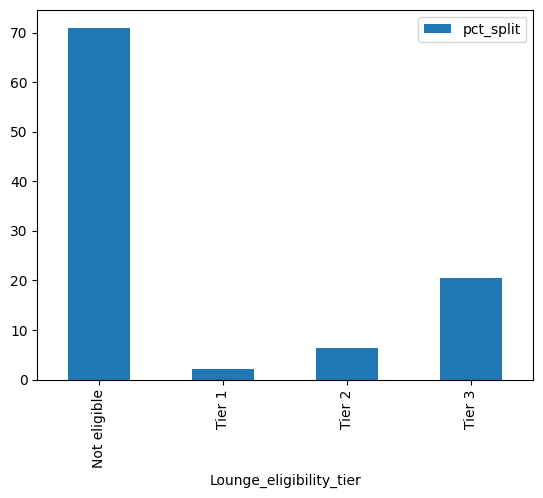

In [94]:
df_tier_baseline1.plot(x = 'Lounge_eligibility_tier', y = 'pct_split', kind = 'bar')

<AxesSubplot: xlabel='Lounge_eligibility_tier'>

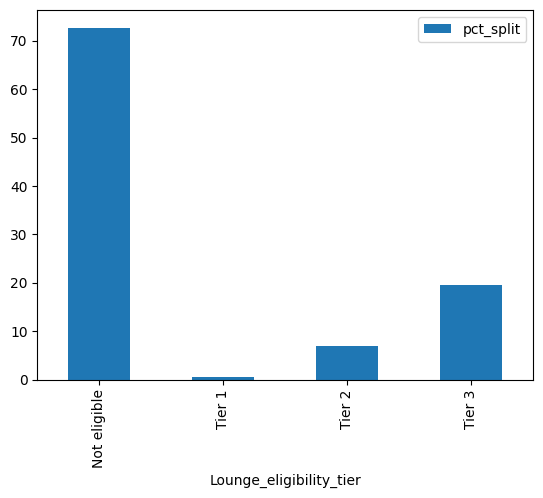

In [95]:
df_nb_tsplit.plot(x = 'Lounge_eligibility_tier', y = 'pct_split', kind = 'bar')

<AxesSubplot: xlabel='Lounge_eligibility_tier'>

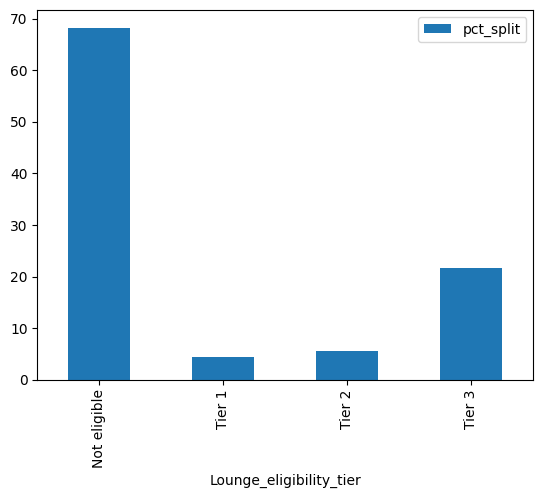

In [96]:
df_wb_tsplit.plot(x = 'Lounge_eligibility_tier', y = 'pct_split', kind = 'bar')